# Mini Project: Monte Carlo Methods

In this notebook, you will write your own implementations of many Monte Carlo (MC) algorithms.  

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

In [1]:
"""Simple blackjack environment

Blackjack is a card game where the goal is to obtain cards that sum to as
near as possible to 21 without going over.  They're playing against a fixed
dealer.
Face cards (Jack, Queen, King) have point value 10.
Aces can either count as 11 or 1, and it's called 'usable' at 11.
This game is placed with an infinite deck (or with replacement).
The game starts with each (player and dealer) having one face up and one
face down card.

The player can request additional cards (hit=1) until they decide to stop
(stick=0) or exceed 21 (bust).

After the player sticks, the dealer reveals their facedown card, and draws
until their sum is 17 or greater.  If the dealer goes bust the player wins.

If neither player nor dealer busts, the outcome (win, lose, draw) is
decided by whose sum is closer to 21.  The reward for winning is +1,
drawing is 0, and losing is -1.

The observation of a 3-tuple of: 
1. the players current sum,
2. the dealer's one showing card (1-10 where 1 is ace),
3. and whether or not the player holds a usable ace (0 or 1).

This environment corresponds to the version of the blackjack problem
described in Example 5.1 in Reinforcement Learning: An Introduction
by Sutton and Barto (1998).
http://incompleteideas.net/sutton/book/the-book.html
"""

"Simple blackjack environment\n\nBlackjack is a card game where the goal is to obtain cards that sum to as\nnear as possible to 21 without going over.  They're playing against a fixed\ndealer.\nFace cards (Jack, Queen, King) have point value 10.\nAces can either count as 11 or 1, and it's called 'usable' at 11.\nThis game is placed with an infinite deck (or with replacement).\nThe game starts with each (player and dealer) having one face up and one\nface down card.\n\nThe player can request additional cards (hit=1) until they decide to stop\n(stick=0) or exceed 21 (bust).\n\nAfter the player sticks, the dealer reveals their facedown card, and draws\nuntil their sum is 17 or greater.  If the dealer goes bust the player wins.\n\nIf neither player nor dealer busts, the outcome (win, lose, draw) is\ndecided by whose sum is closer to 21.  The reward for winning is +1,\ndrawing is 0, and losing is -1.\n\nThe observation of a 3-tuple of: \n1. the players current sum,\n2. the dealer's one show

### Part 0: Explore BlackjackEnv

Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [2]:
import gym
from IPython.display import Image
env = gym.make('Blackjack-v0')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card [Jack, Queen, King] $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [3]:
# print the state space and action space
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Execute the code cell below to play Blackjack with **a random policy**.  

(_The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to get some experience with the output that is returned as the agent interacts with the environment._)

In [4]:
for i_episode in range(3):
    state = env.reset()
    while True:
        print('Current state: {}'.format(state))
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

Current state: (13, 9, False)
End game! Reward:  -1.0
You lost :(

Current state: (18, 3, False)
End game! Reward:  -1
You lost :(

Current state: (17, 8, False)
End game! Reward:  -1.0
You lost :(



### Part 1: MC Prediction: State Values

In this section, you will write your own implementation of MC prediction (for estimating the state-value function).

We will begin by investigating a policy where the player always sticks if the sum of her cards exceeds 18.  The function `generate_episode_from_limit` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [5]:
"""
 A policy where the player always sticks (the dealer reveals their 
 facedown card, and draws until their sum is 17 or greater.)
 if the sum of her cards exceeds 18
"""
def generate_episode_from_limit(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        action = 0 if state[0] > 18 else 1 #Stick = 0, Hit = 1
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Execute the code cell below to play Blackjack with the policy. 

(*The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to gain some familiarity with the output of the `generate_episode_from_limit` function.*)

In [6]:
for i in range(5):
    print("\n" +'-'*10 + 'Game(' + str(i+1) + ')' + '-'*10)
    print(generate_episode_from_limit(env))


----------Game(1)----------
[((19, 10, True), 0, 1.0)]

----------Game(2)----------
[((12, 10, False), 1, -1)]

----------Game(3)----------
[((17, 5, False), 1, -1)]

----------Game(4)----------
[((12, 5, False), 1, -1)]

----------Game(5)----------
[((11, 1, False), 1, 0), ((19, 1, False), 0, 0.0)]


The pseudocode for **(first-visit)** MC prediction (for the state values) can be found below. (Feel free to implement either the first-visit or every-visit MC method. In the game of Blackjack, both the first-visit and every-visit methods return identical results.)

#### Pseudocode of First-visit MC prediction

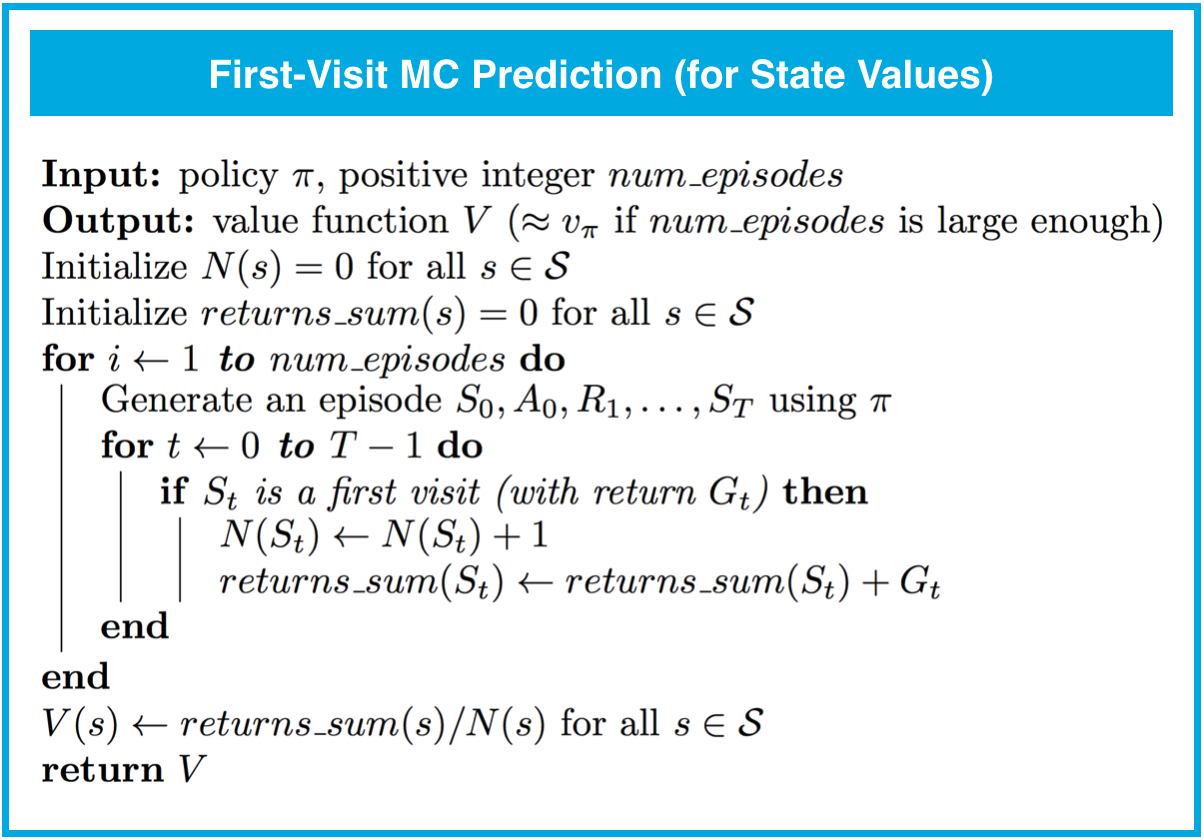

In [7]:
Image(filename='img/mc-pred-state.png', width=700)

Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either **first-visit** or **every-visit MC prediction**; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the **discount rate**.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `V`: This is a dictionary where `V[s]` is the estimated value of state `s`.  For example, if your code returns the following output:
```
{(4, 7, False): -0.38775510204081631, (18, 6, False): -0.58434296365330851, (13, 2, False): -0.43409090909090908, (6, 7, False): -0.3783783783783784, ...
```
then the value of state `(4, 7, False)` was estimated to be `-0.38775510204081631`.

If you are unfamiliar with how to use `defaultdict` in Python, you are encouraged to check out [this source](https://www.accelebrate.com/blog/using-defaultdict-python/).

In [8]:
from collections import defaultdict
import numpy as np
import sys

"""
Generate_episode:
We will begin by investigating a policy where the player always 
sticks if the sum of her cards exceeds 18. 

The function generate_episode_from_limit samples an episode 
using this policy.
"""
def mc_prediction_v(env, num_episodes, generate_episode, gamma=1.0):
    
    # initialize empty dictionary of lists
    returns = defaultdict(list)
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # generate an episode
        episode = generate_episode(env)
        
        # obtain the states, actions, and rewards
        # Sai: *episode means When calling a function, the * operator can be used to unpack an iterable into the arguments in the function call
        # https://treyhunner.com/2018/10/asterisks-in-python-what-they-are-and-how-to-use-them/#Asterisks_for_unpacking_into_function_call
        states, actions, rewards = zip(*episode)
        
        # prepare for discounting
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        
        
        # Gt = sum(rewards[i:]*discounts[:-(1+i)])
        # Gt = Rt+1 + Rt+2 + Rt+3 + ··· + RT, where T is a final time step.
        """   
        # OPTION 1: FIRST-VISIT MC PREDICTION
        visited = set()
        for i, state in enumerate(states):
            if state not in visited:
                visited.add(state)
                returns[state].append(sum(rewards[i:]*discounts[:-(1+i)]))
         """   
            
        # OPTION 2: EVERY-VISIT MC PREDICTION 
        # calculate and store the return for each visit in the episode
        for i, state in enumerate(states):
            returns[state].append(sum(rewards[i:]*discounts[:-(1+i)]))
    
    # calculate the state-value function estimate
    V = {k: np.mean(v) for k, v in returns.items()}
    return V

Use the cell below to calculate and plot the **state-value function estimate**.  (_The code for plotting the value function has been borrowed from [this source](https://github.com/dennybritz/reinforcement-learning/blob/master/lib/plotting.py) and slightly adapted._)

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

Episode 500000/500000.

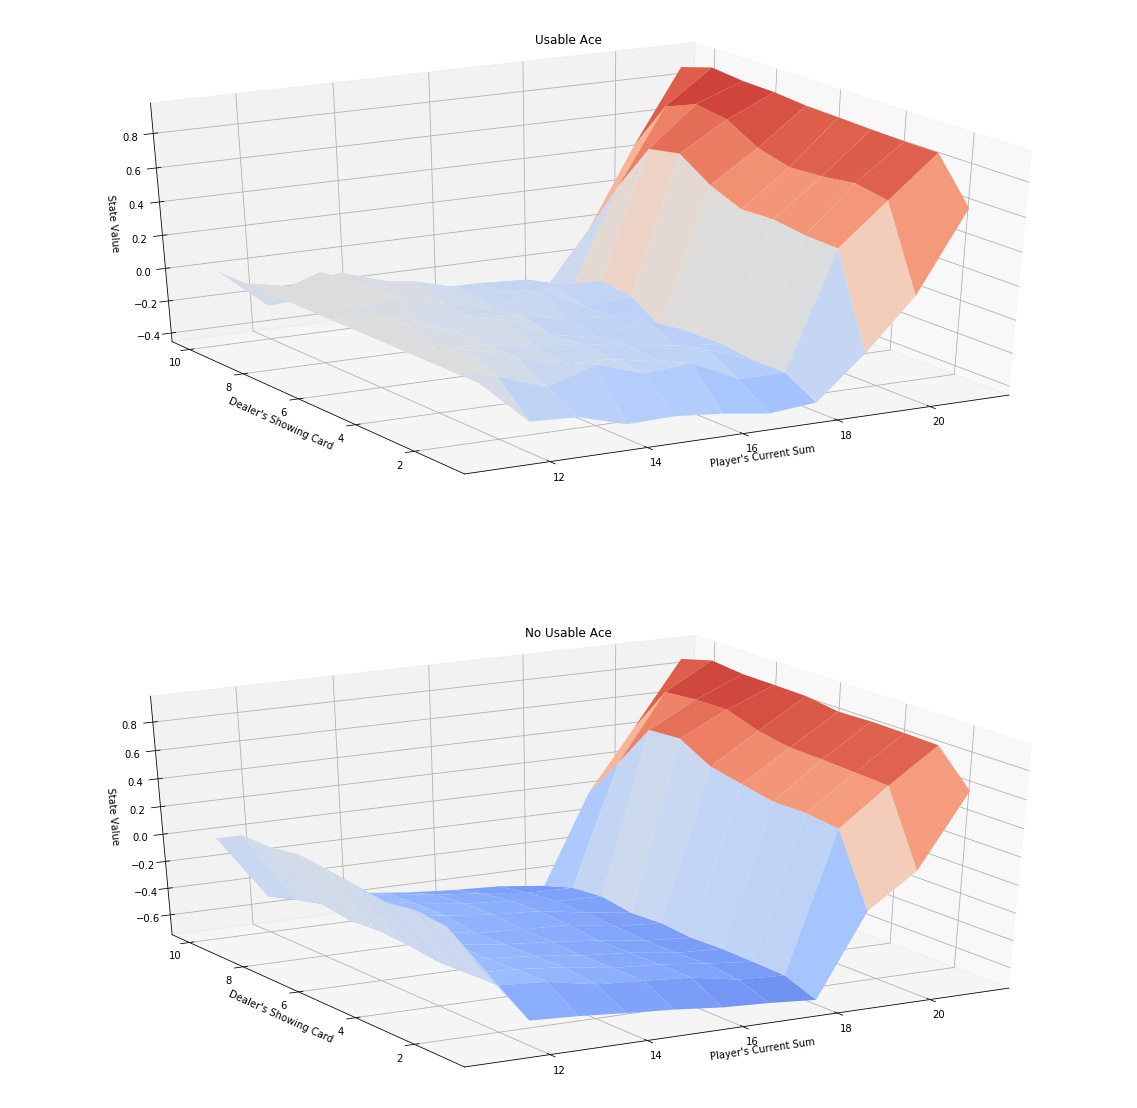

In [23]:
from plot_utils import plot_blackjack_values

# obtain the value function
V = mc_prediction_v(env, 500000, generate_episode_from_limit)

# plot the value function
plot_blackjack_values(V)

### Part 2: MC Prediction: Action Values

In this section, you will write your own implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [10]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either **first-visit** or **every-visit MC prediction**; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [11]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # generate an episode
        episode = generate_episode(env)
        # obtain the states, actions, and rewards
        states, actions, rewards = zip(*episode)
        # prepare for discounting
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        # update the sum of the returns, number of visits, and action-value 
        # function estimates for each state-action pair in the episode
        for i, state in enumerate(states):
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
    return Q

Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

Episode 500000/500000.

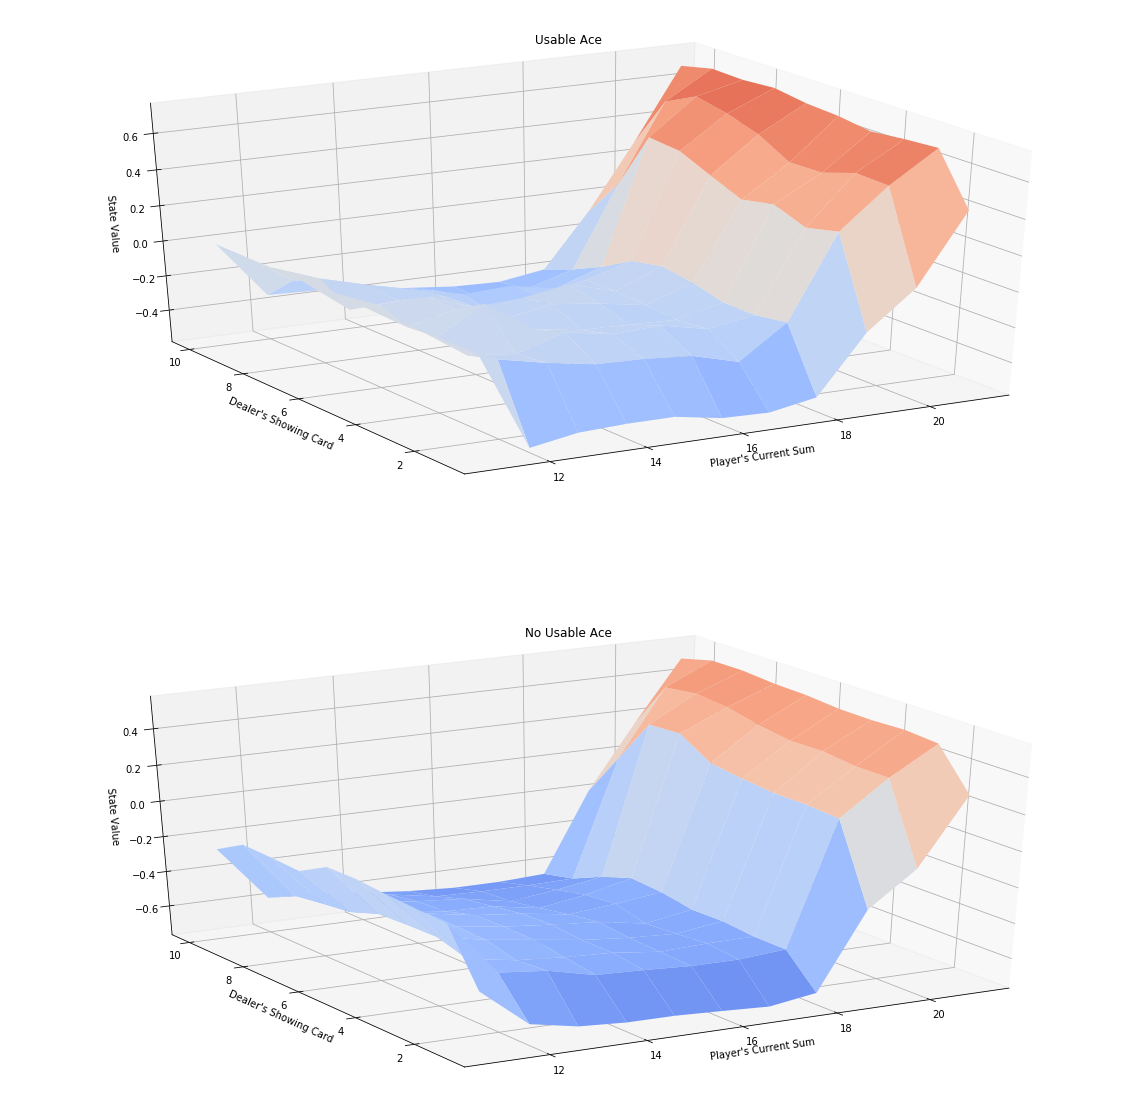

In [12]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, generate_episode_from_limit_stochastic)

# obtain the state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### Result:
The agent needs to play blackjack about 500,000 times to get a good estimate of the value function. In the context of policy iteration, this seems like way too long to spend evaluating a policy before trying to improve it. Maybe it would make more sense to improve the policy after every individual game of blackjack. 

Instead of waiting for the agent to evaluate a policy before trying to improve it, maybe what we could do instead is iteratively update the estimate after every visit. (We will do it in part 3!) 

### Part 3: MC Control: GLIE (Running estimate mean)

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

#### Analogous pseudocode  (for taking a running estimate mean of a sequence (x1, x2, ......, xn))

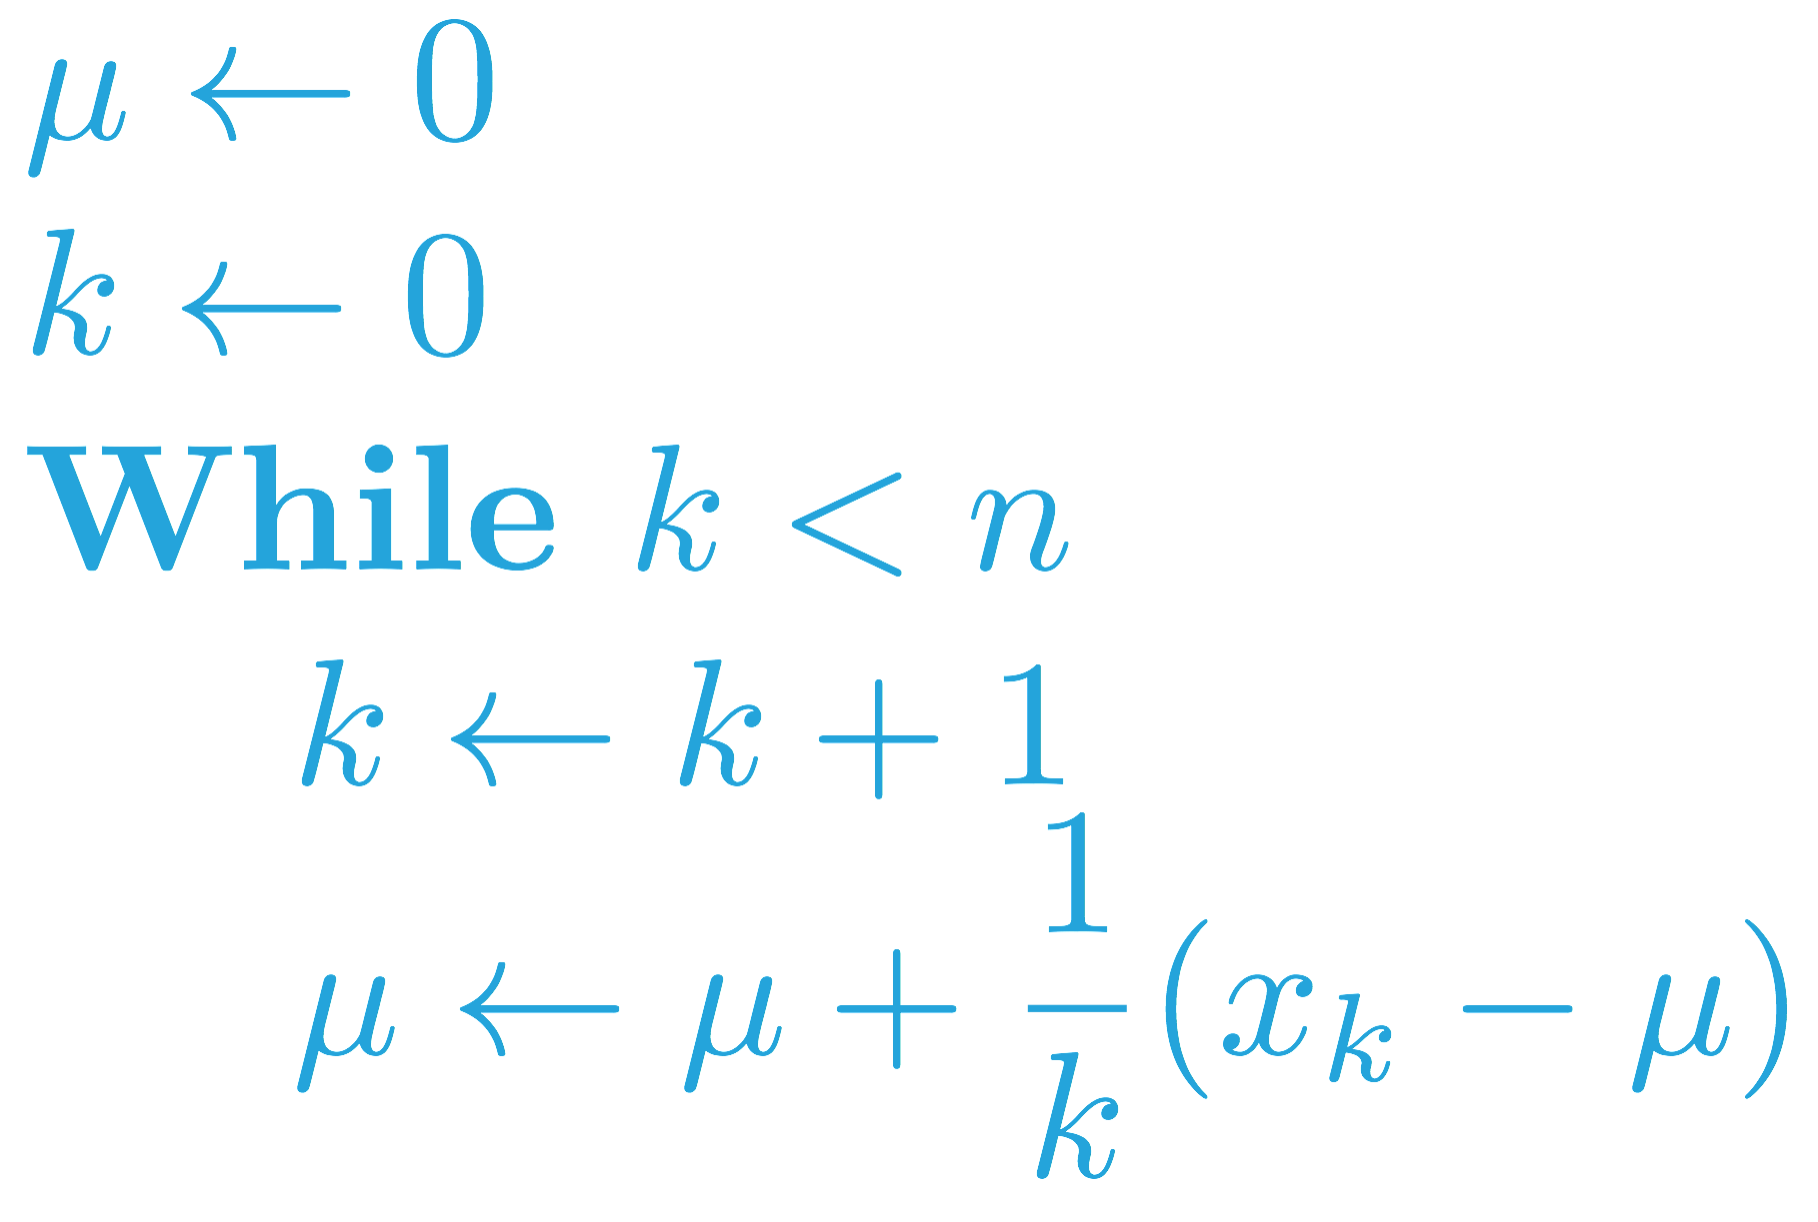

In [35]:
Image(filename='img/incremental.png', width=300)

#### Pseudocode of GLIE MC prediction

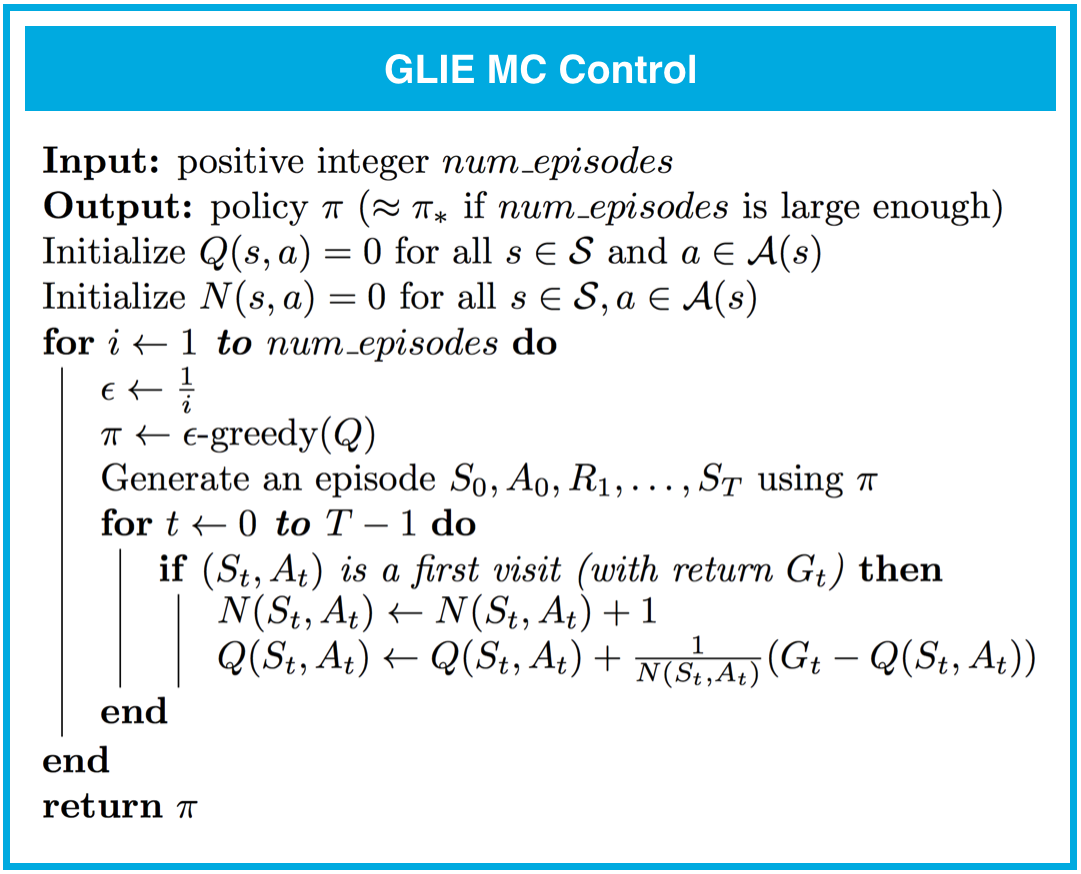

In [16]:
Image(filename='img/mc-control-glie.png', width=700)

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

In [24]:
def get_probs(Q_s, epsilon, nA):
    """ 
    obtains the action probabilities corresponding to epsilon-greedy policy
    Returns the policy for the Q value given
    """
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s


# IMPORTANT METHOD!
def generate_episode_from_Q(env, Q, epsilon, nA):
    """ 
    generates an episode from following the epsilon-greedy policy containing the state, action and reward for 
    each time step in the episode.
    Returns all step information for that episode
    """
    episode = []
    state = env.reset()
    while True:
        
        # Retrive action following policy.
        probs = get_probs(Q[state], epsilon, nA)
        action = np.random.choice(np.arange(nA), p=probs) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode


def update_Q_GLIE(env, episode, Q, N, gamma):
    """ 
    updates the action-value function estimate using the most recent episode 
    """
    states, actions, rewards = zip(*episode)
    
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    
    # Calculate reward for the state-action visit.
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        old_N = N[state][actions[i]]
        Q[state][actions[i]] = old_Q + (sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)/(old_N+1)
        N[state][actions[i]] += 1
    return Q, N


def best_policy(Q,nA):
    """
    returns the best actions for each Q value in the policy
    """
    return dict((k,np.argmax(v)) for k, v in Q.items())

In [25]:
def mc_control_GLIE(env, num_episodes, gamma=1.0):
    
    nA = env.action_space.n
    
    # initialize empty dictionaries of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    N = defaultdict(lambda: np.zeros(nA))
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        # set the value of epsilon
        epsilon = 1.0/((i_episode/8000)+1)
        
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        
        # update the action-value function estimate using the episode
        Q, N = update_Q_GLIE(env, episode, Q, N, gamma)
        
    # determine the policy corresponding to the final action-value function estimate
    policy = best_policy(Q, nA)
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.

In [26]:
# obtain the estimated optimal policy and action-value function
policy_glie, Q_glie = mc_control_GLIE(env, 500000)

Episode 500000/500000.

Next, we plot the corresponding state-value function.

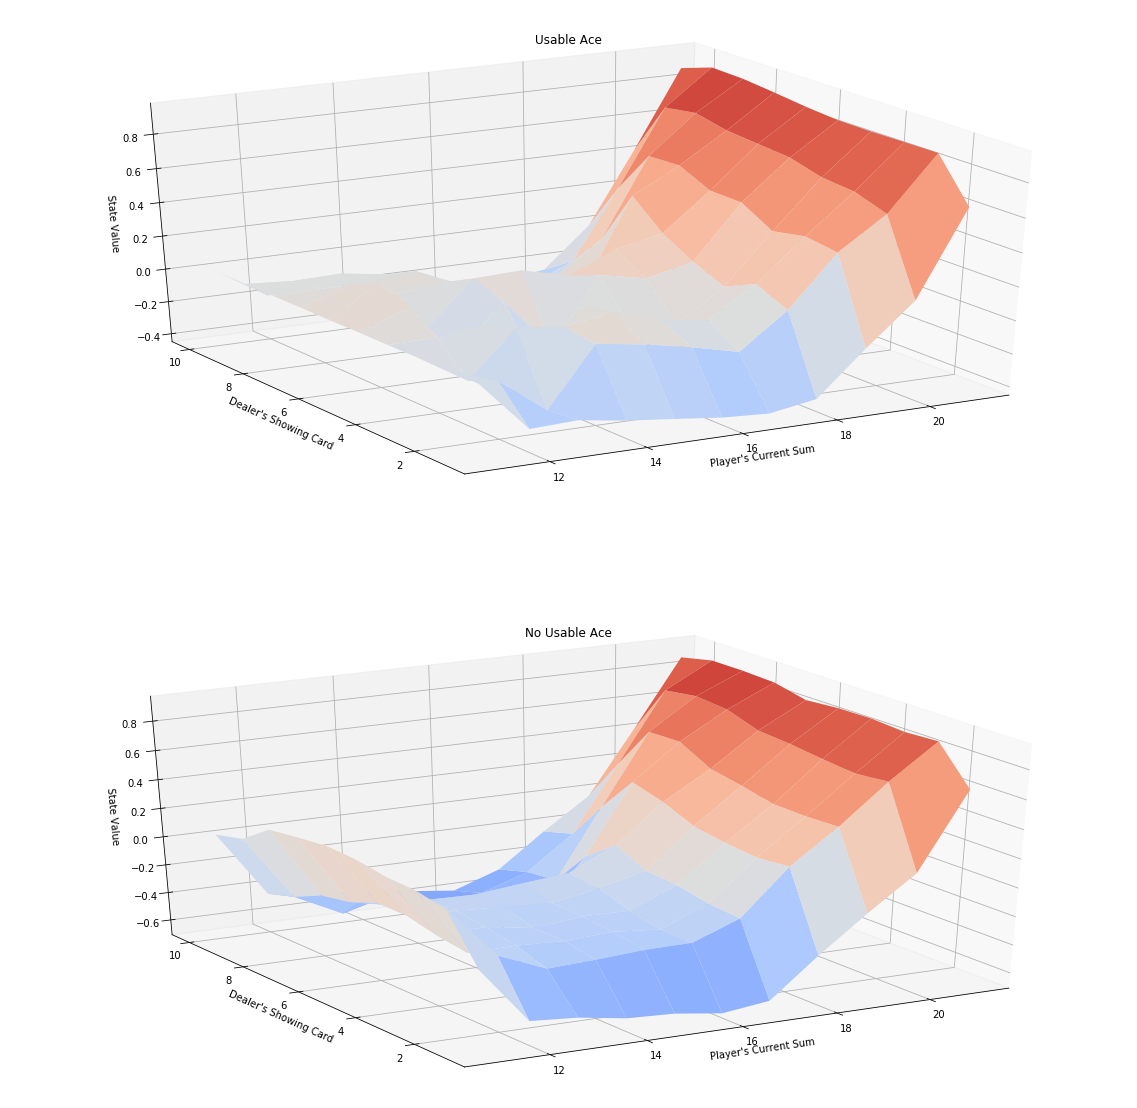

In [27]:
# obtain the state-value function
V_glie = dict((k,np.max(v)) for k, v in Q_glie.items())

# plot the state-value function
plot_blackjack_values(V_glie)

Finally, we visualize the policy that is estimated to be optimal.

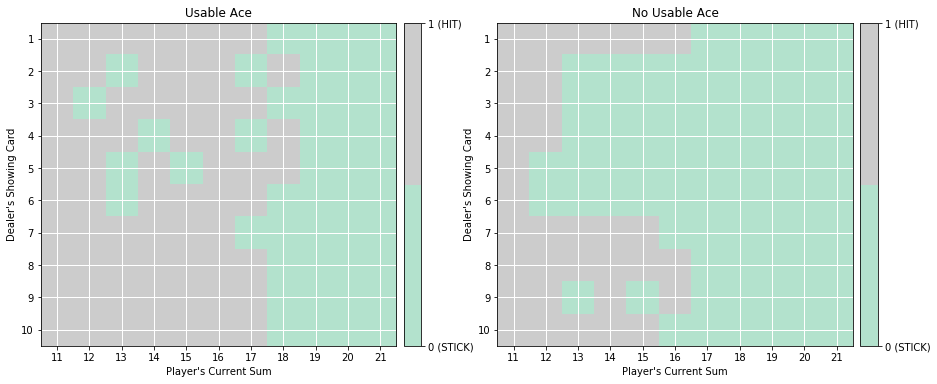

In [28]:
from plot_utils import plot_policy

# plot the policy
plot_policy(policy_glie)

The **true** optimal policy $\pi_*$ can be found on page 82 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$ and/or run the algorithm for more episodes to attain better results.

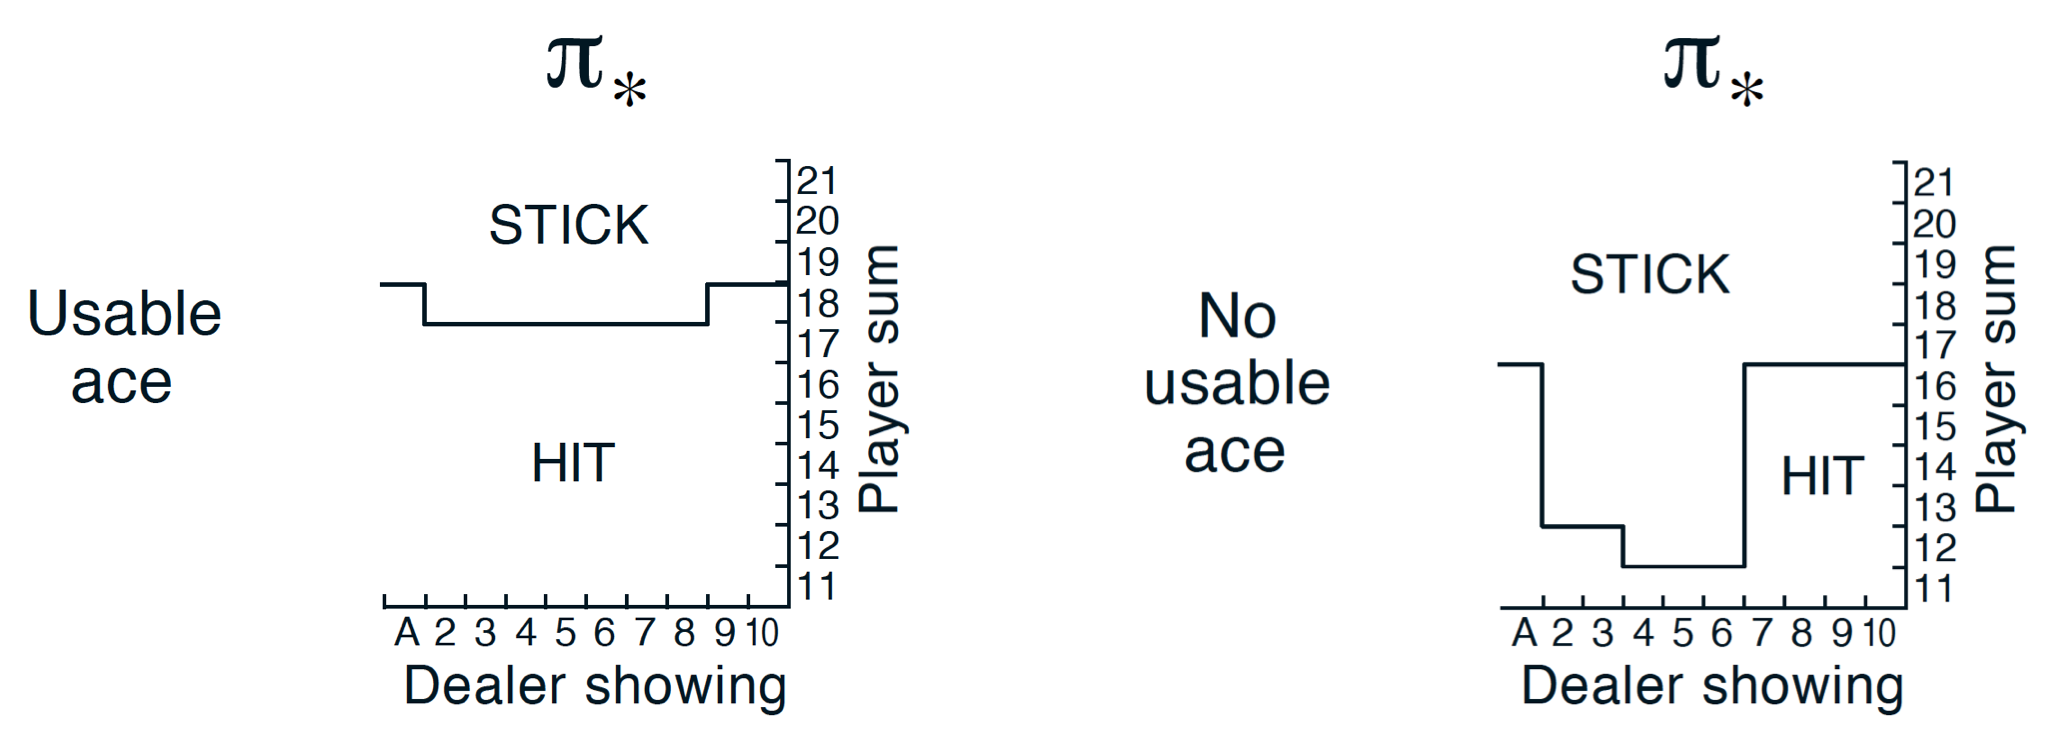

In [30]:
Image(filename='img/optimal.png', width=700)

### Part 4: MC Control: Constant-$\alpha$(A forgetful mean of a sequence)

In part 3, the sampled returns (for the same state-action pair) likely corresponds to many **different policies**. This is because the control algorithm proceeds as a sequence of alternating evaluation and improvement steps, where the policy is improved after every episode of interaction. In particular, we discussed that returns sampled at later time steps likely correspond to policies that are more optimal.

That said, the sampled returns (for the **same state-action pair**) likely corresponds to many **different** policies. This is because the control algorithm proceeds as a sequence of alternating evaluation and improvement steps, where the policy is improved after every episode of interaction. In particular, we discussed that returns sampled at later time steps likely correspond to policies that are more optimal.

With that in mind, it made sense to amend the policy evaluation step to instead use a constant step size, which we denoted by **α**. 

*This ensures that the agent primarily considers the most recently sampled returns when estimating the action-values and gradually forgets about returns in the distant past. This is quite important because remember that the policy is constantly changing!*

#### From **running mean** to **forgetful mean (α)** policy evaluation step:

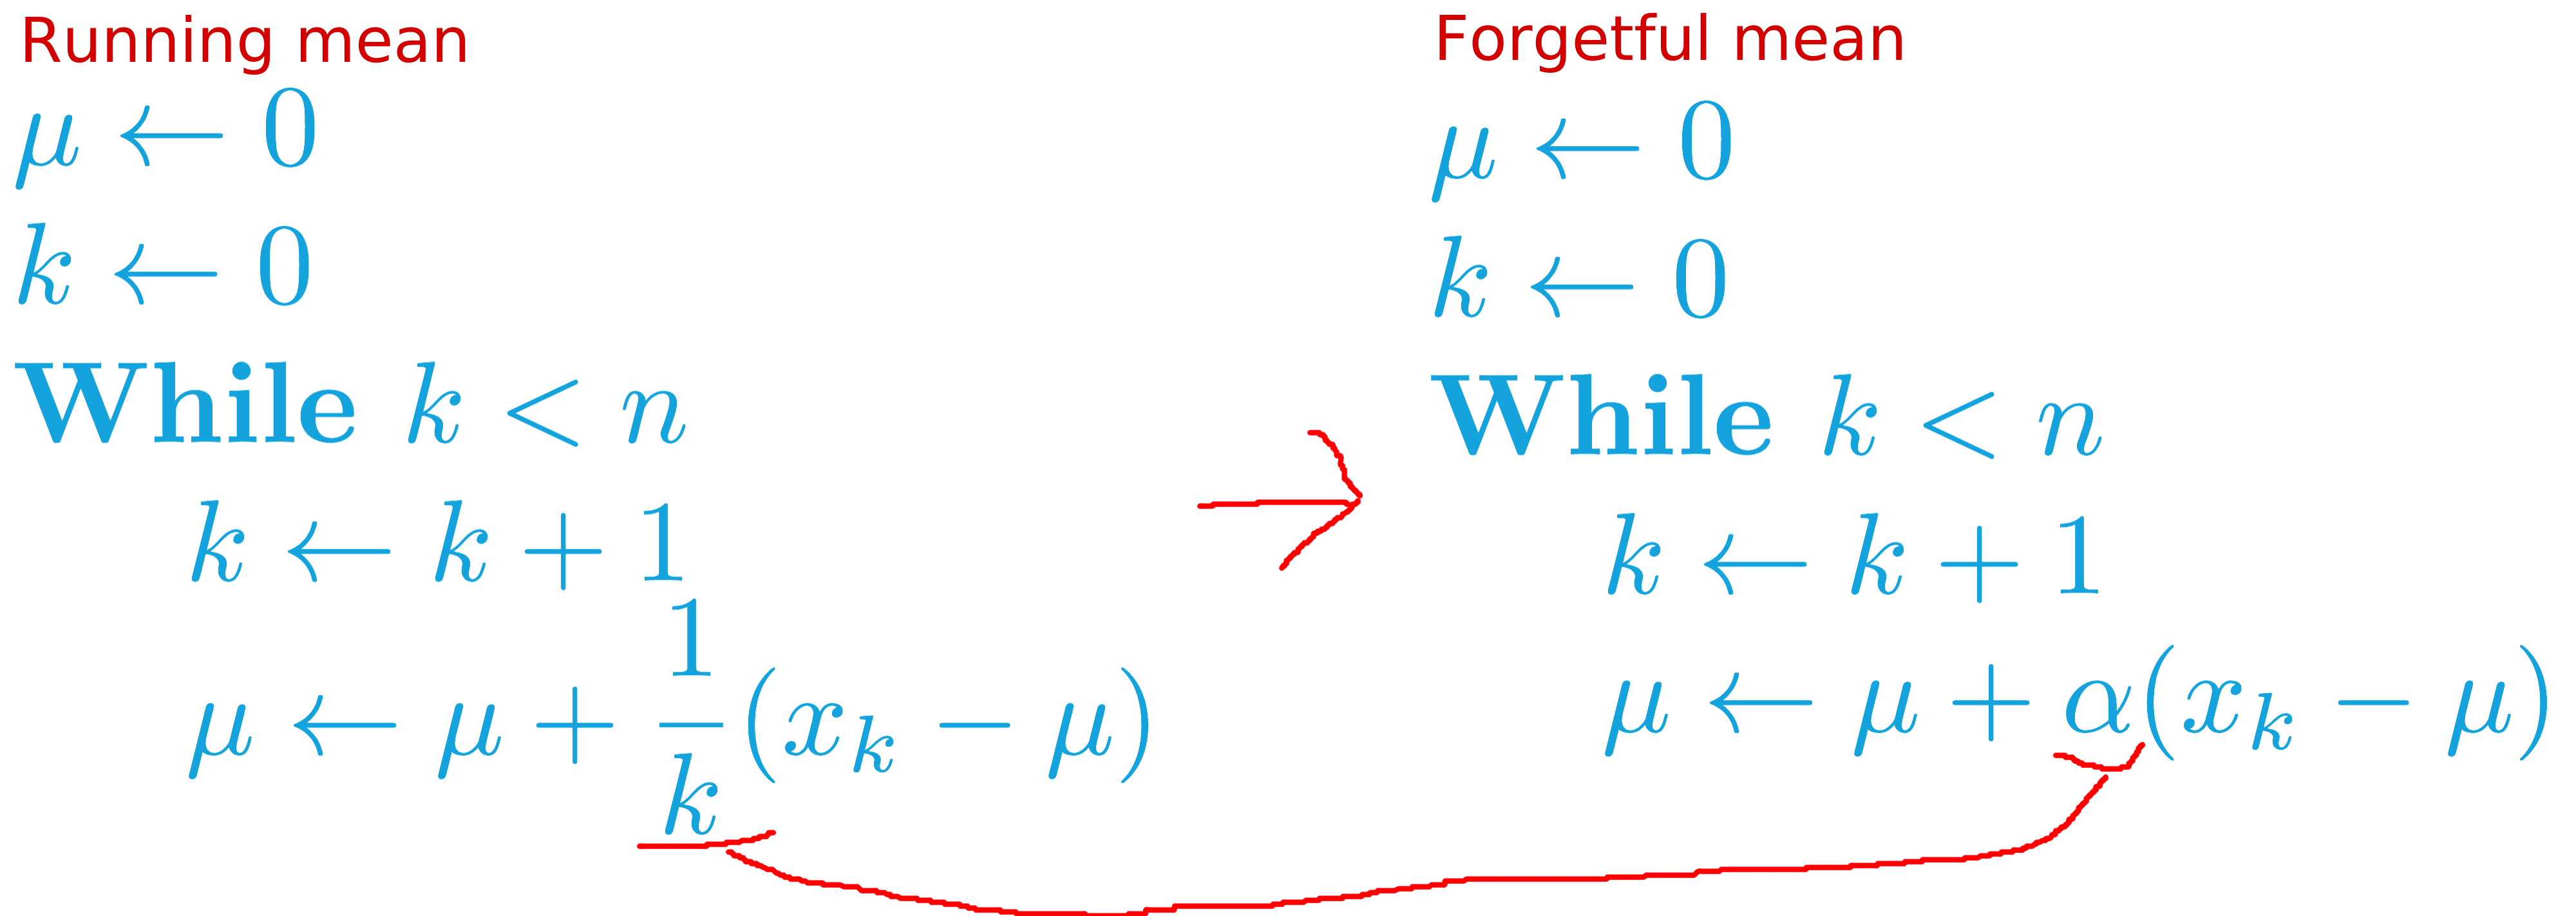

In [32]:
Image(filename='img/incremental_to_constant-alpha.png', width=700)

#### Example of runing mean and forgetful mean

In [36]:
import numpy as np

def running_mean(x):
    mu = 0
    mean_values = []
    for k in np.arange(0, len(x)):
        mu = mu + (1.0/(k+1))*(x[k] - mu)
        mean_values.append(mu)
    return mean_values
    
def forgetful_mean(x, alpha):
    mu = 0
    mean_values = []
    for k in np.arange(0, len(x)):
        mu = mu + alpha*(x[k] - mu)
        mean_values.append(mu)
    return mean_values

def testing_results():

    # This is the sequence (corresponding to successively sampled returns). 
    # Feel free to change it!
    x = np.hstack((np.ones(10), 10*np.ones(10)))
    
    # These are the different step sizes alpha that we will test.  
    # Feel free to change it!
    alpha_values = np.arange(0,.3,.01)+.01

    """
    prints the mean of the sequence "x" (as calculated by the
    running_mean function), along with analogous results for each value of alpha 
    in "alpha_values" (as calculated by the forgetful_mean function).
    """
    print('The running_mean function returns:', running_mean(x)[-1])
    print('The forgetful_mean function returns:')
    for alpha in alpha_values:
        print(np.round(forgetful_mean(x, alpha)[-1],4), \
        '(alpha={})'.format(np.round(alpha,2)))

In [37]:
testing_results()

The running_mean function returns: 5.5
The forgetful_mean function returns:
1.0427 (alpha=0.01)
1.9787 (alpha=0.02)
2.8194 (alpha=0.03)
3.5745 (alpha=0.04)
4.2529 (alpha=0.05)
4.8624 (alpha=0.06)
5.4099 (alpha=0.07)
5.9018 (alpha=0.08)
6.3436 (alpha=0.09)
6.7403 (alpha=0.1)
7.0964 (alpha=0.11)
7.4159 (alpha=0.12)
7.7025 (alpha=0.13)
7.9593 (alpha=0.14)
8.1894 (alpha=0.15)
8.3953 (alpha=0.16)
8.5795 (alpha=0.17)
8.7441 (alpha=0.18)
8.891 (alpha=0.19)
9.0221 (alpha=0.2)
9.1389 (alpha=0.21)
9.2428 (alpha=0.22)
9.3352 (alpha=0.23)
9.4173 (alpha=0.24)
9.49 (alpha=0.25)
9.5544 (alpha=0.26)
9.6114 (alpha=0.27)
9.6616 (alpha=0.28)
9.706 (alpha=0.29)
9.745 (alpha=0.3)


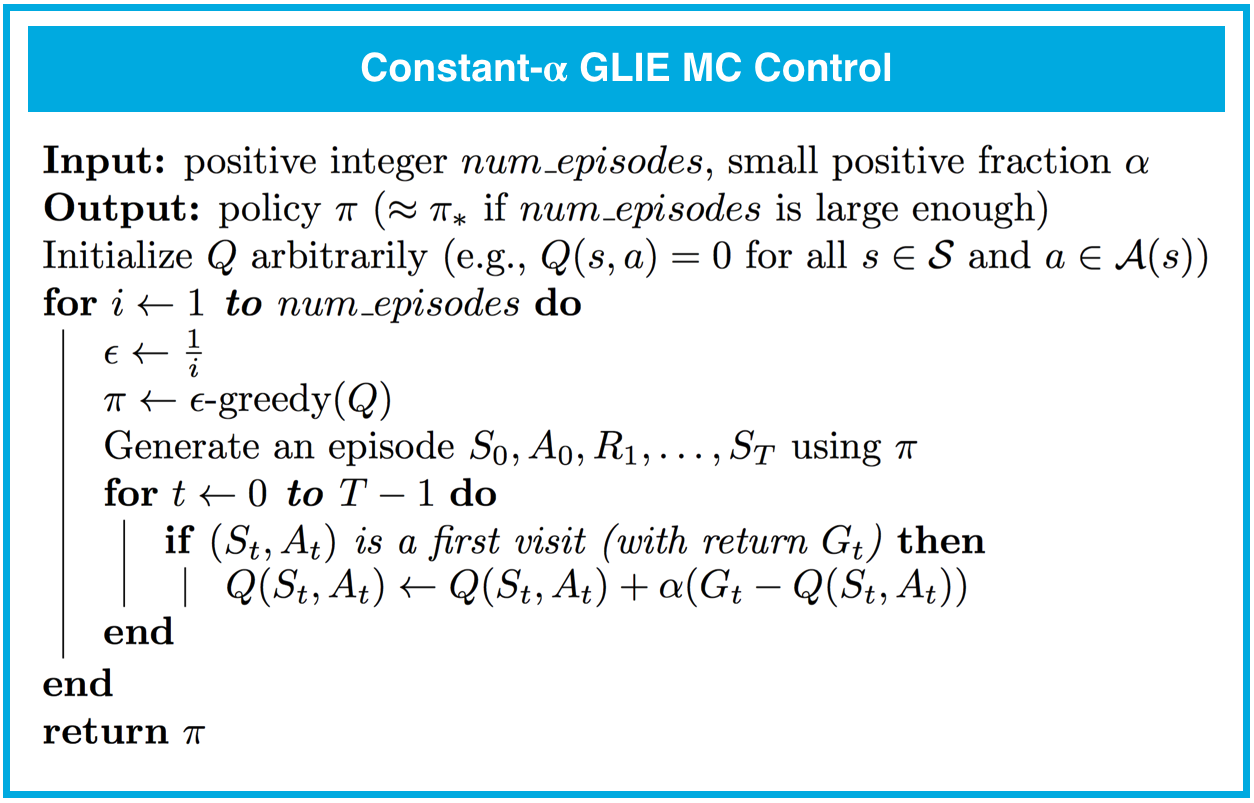

In [38]:
Image(filename='img/mc-control-constant-a.png', width=700)

In below section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

In [39]:
def update_Q_alpha(env, episode, Q, alpha, gamma):
    """ 
    Updates the action-value function estimate using the most recent episode 
    Returns the new Q policy
    """
    
    states, actions, rewards = zip(*episode)
    
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    
    # Calculate reward for the state-action visit.
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

In [45]:
def mc_control_alpha(env, num_episodes, alpha, gamma=1.0):
    """
    main method. Iterates through episodes updating epsilon after each, 
    retrieves the list of states, actions and rewards from the last episode 
    and use them to calculate the updated Q values
    """
    
    nA = env.action_space.n
    
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        # set the value of epsilon
        epsilon = 1.0/((i_episode/8000)+1)
        
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        
        # update the action-value function estimate using the episode
        Q = update_Q_alpha(env, episode, Q, alpha, gamma)
        
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.

In [46]:
# obtain the estimated optimal policy and action-value function
policy_alpha, Q_alpha = mc_control_alpha(env, 500000, 0.01)

Episode 500000/500000.

Next, we plot the corresponding state-value function.

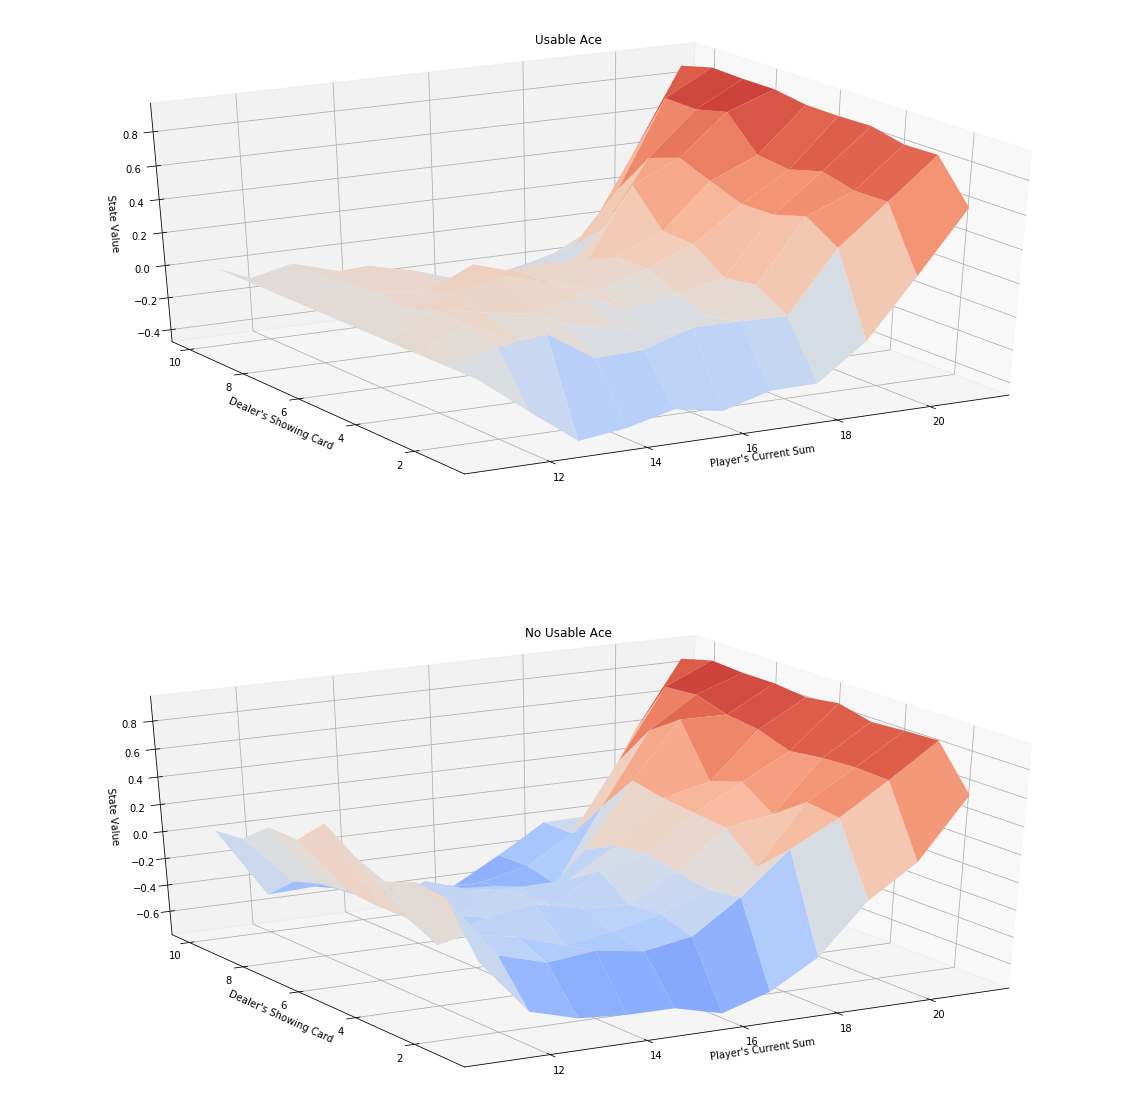

In [47]:
# obtain the state-value function
V_alpha = dict((k,np.max(v)) for k, v in Q_alpha.items())

# plot the state-value function
plot_blackjack_values(V_alpha)

Finally, we visualize the policy that is estimated to be optimal.

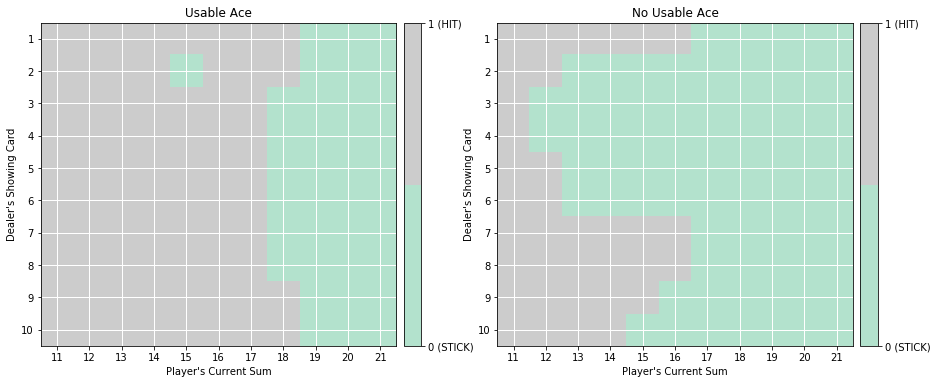

In [48]:
# plot the policy
plot_policy(policy_alpha)

The **true** optimal policy $\pi_*$ can be found on page 82 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

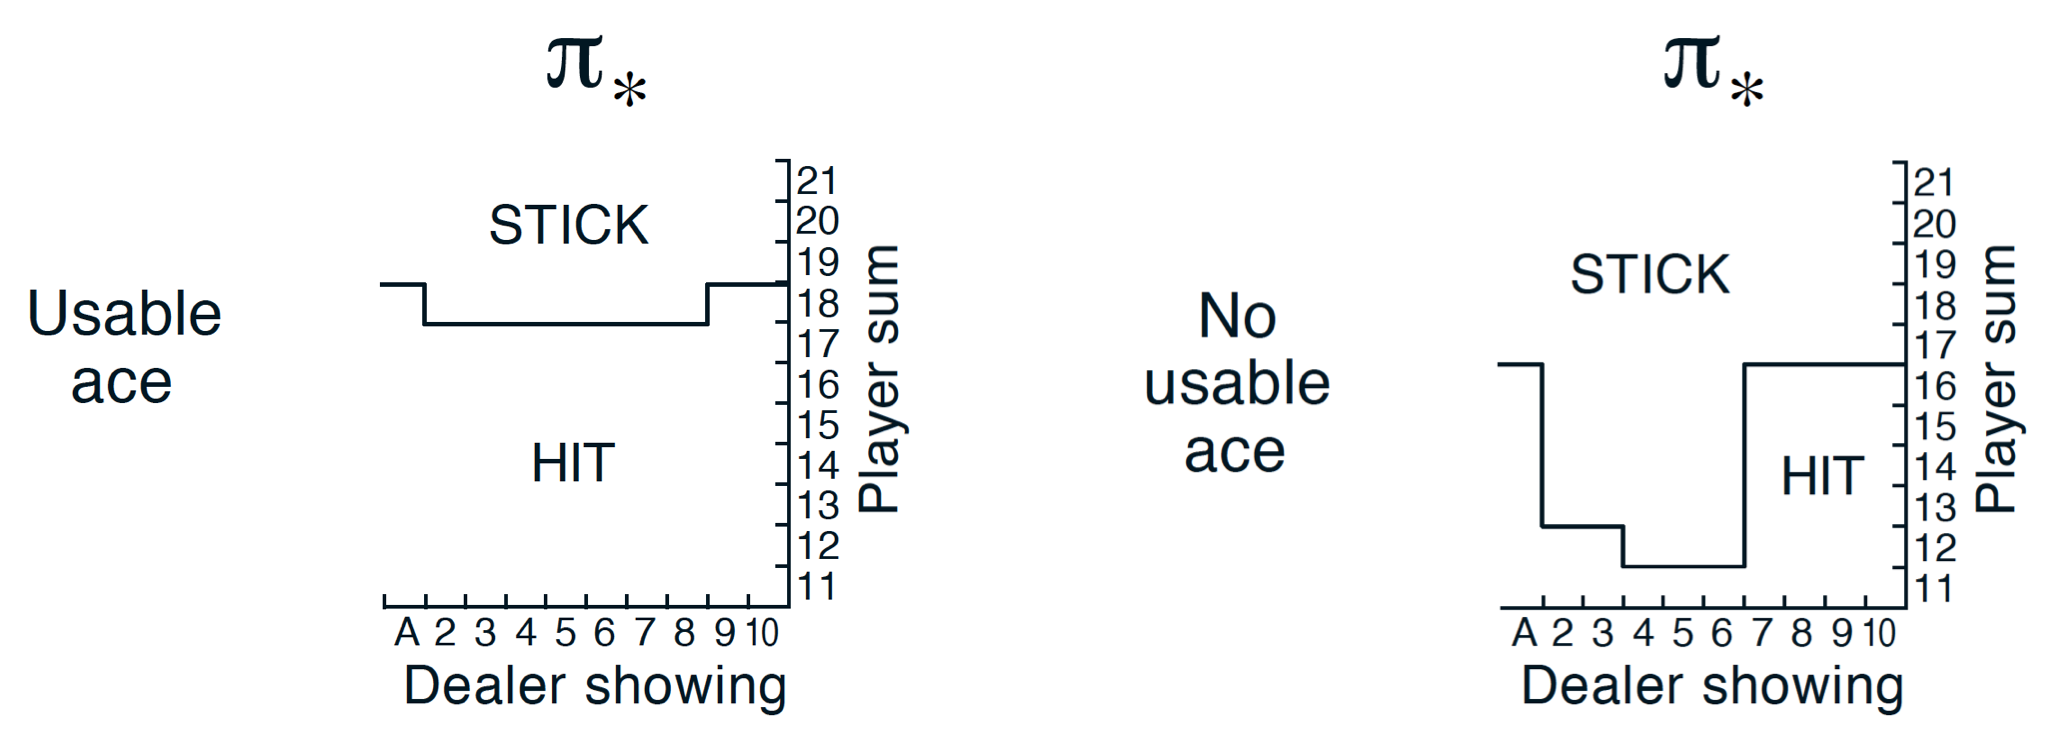

In [31]:
Image(filename='img/optimal.png', width=700)